> **Note:** Run all cells to reproduce results.

# Beauty Wizard: Cosmetic Ingredient Transparency & Regulatory Indicators

## 1. Introduction

This project examines cosmetic product formulations, ingredient usage patterns, and regulatory reporting signals by integrating retail product data and government chemical reporting into a relational SQLite database.

**Core Questions:**

- Which ingredients are most prevalent across cosmetic products?
- How complex are typical cosmetic formulations?
- Do higher-priced or higher-ranked products differ in ingredient diversity or risk indicators?
- Which ingredients and brands appear most frequently in regulatory reporting datasets?

## 2. Imports & Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import re
import seaborn as sns
import sqlite3

## 3. Data Sources

- Sephora Skincare Product Ingredients (Kaggle CSV) (cosmetic_p.csv)
- BeautyFeeds Skincare & Haircare Dataset (BeautyFeeds.csv)
- California Safe Cosmetics Program (CSCP) Open Data (cscpopendata.csv)

In [2]:
# Import data
DATA = Path("data")

cosmetic = pd.read_csv(DATA / "cosmetic_p.csv")
beauty = pd.read_csv(DATA / "BeautyFeeds.csv")
cscp = pd.read_csv(DATA / "cscpopendata.csv")

## 4. Data Cleaning & Standardization
- Standardized text (case, whitespace, and characters).
- Consistent column naming.
- Uniform missing-value handling.
- Consistent data types.
- Reusable cleaning logic across datasets.

In [3]:
# Standardize text fields: trim whitespace, collapse repeated spaces, convert to lowercase, preserve missing values
def normalize_text(value):
    if pd.isna(value):
        return None
    value = str(value).strip()
    value = re.sub(r"\s+", " ", value)
    return value.lower()

In [4]:
# Column name normalization
def normalize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    return df

In [5]:
# Generic dataframe text normalization
def normalize_text_columns(df, columns):
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df[col] = df[col].apply(normalize_text)
    return df

### Apply normalization to each dataset

In [6]:
# Cosmetic product dataset
cosmetic = normalize_columns(cosmetic)

# Rename product category labels for clearer semantics
cosmetic.rename(columns={'label': 'product_type'}, inplace=True)
cosmetic.rename(columns={'name': 'product_name'}, inplace=True)

# Text normalization
cosmetic = normalize_text_columns(
    cosmetic,
    ['brand', 'product_name', 'product_type', 'ingredients']
)

# Remove rows missing key evaluation metrics
cosmetic_cleaned = cosmetic.dropna(subset=['rank'])

In [7]:
# BeautyFeeds dataset
beauty = normalize_columns(beauty)

# Rename product category labels for clearer semantics
beauty.rename(columns={'type': 'product_type'}, inplace=True)
beauty.rename(columns={'name': 'product_name'}, inplace=True)

# Text normalization
beauty = normalize_text_columns(
    beauty,
    ['ingredients', 'brand', 'name']
)

beautyfeeds_cleaned = beauty.copy()

In [8]:
# Drop unused index column
if 'Unnamed: 0' in cscp.columns:
    cscp.drop(columns=['Unnamed: 0'], inplace=True)
    
# CSCP chemical reports dataset
cscp = normalize_columns(cscp)

# Rename product category labels for clearer semantics
cscp.rename(columns={'type': 'product_type'}, inplace=True)
cscp.rename(columns={'name': 'product_name'}, inplace=True)

# Text normalization
cscp = normalize_text_columns(
    cscp,
    ['chemicalname']
)

cscp_cleaned = cscp.copy()

### Ingredient (granular) normalization

In [9]:
def clean_ingredient_column(df, ingredient_col):
    """
    Standardize ingredient text and return a dataframe
    with cleaned and tokenized ingredient lists.
    """
    df = df.copy()

    # Ensure string type
    df[ingredient_col] = df[ingredient_col].astype(str)

    # Remove special characters (preserve commas)
    df['clean_ingredients'] = df[ingredient_col].apply(
        lambda x: re.sub(r'[^a-zA-Z0-9,\s]', '', x)
    )

    # Split into list and strip whitespace
    df['ingredient_list'] = df['clean_ingredients'].str.split(',')
    df['ingredient_list'] = df['ingredient_list'].apply(
        lambda lst: [item.strip() for item in lst if item.strip()]
    )

    # Normalize each ingredient token
    df['ingredient_list_norm'] = df['ingredient_list'].apply(
        lambda lst: [normalize_text(i) for i in lst]
    )

    return df

# Ingredient-specific logic
cosmetic = clean_ingredient_column(cosmetic, 'ingredients')

### Missing Data Handling

Product data `(cosmetic)`

In [10]:
# Coerce price to numeric, invalid values become NaN
cosmetic['price'] = pd.to_numeric(cosmetic['price'], errors='coerce')

# Fill missing categorical values
cosmetic['brand'] = cosmetic['brand'].fillna('Unknown')

# Remove rows missing key evaluation metrics, creating rank-valid subset
cosmetic_cleaned = cosmetic.dropna(subset=['rank'])

Ingredients data `(beauty)`

In [11]:
# Coerce numeric values
beauty['price'] = pd.to_numeric(beauty['price'], errors='coerce')

# Fill missing categorical values that actually exist
beauty['brand'] = beauty['brand'].fillna('Unknown')
beauty['product_type'] = beauty['product_type'].fillna('Unknown')

# Require ingredient text
beauty_cleaned = beauty.dropna(subset=['ingredients'])

Chemical reporting data `(cscp)`

In [12]:
# Coerce report count to numeric
cscp['chemicalcount'] = pd.to_numeric(cscp['chemicalcount'], errors='coerce')

- Missing values were handled using dataset-specific strategies, preserving rows unless key evaluation metrics were absent.

### Outlier Handling

In [13]:
# IQR method to flag extreme values:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

In [14]:
# Outliers by price:
price_outliers = detect_outliers_iqr(cosmetic["price"])
price_outliers.count()

np.int64(91)

In [15]:
#Flag instead of drop
cosmetic["price_outlier"] = cosmetic["price"].isin(price_outliers)

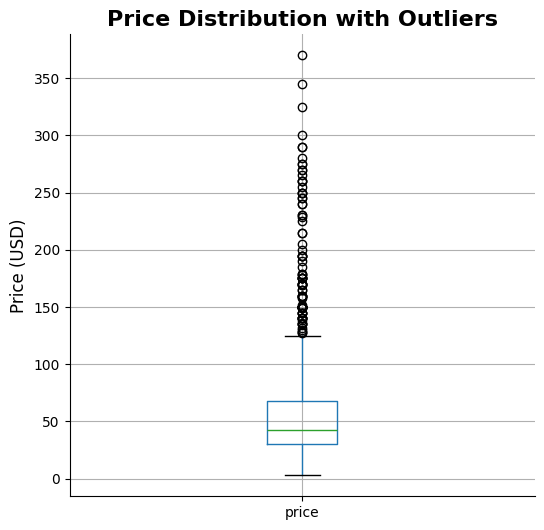

In [90]:
plt.figure(figsize=(6, 6))
cosmetic.boxplot(column="price")
plt.title("Price Distribution with Outliers", fontsize=16, weight='bold')
plt.ylabel("Price (USD)", fontsize=12)
sns.despine()
plt.show()

- Price outliers were identified using IQR and visual inspection, and flagged for transparency rather than removed indiscriminately.
- Outliers were retained in the EDA and noted where relevant to preserve real-world variability in product pricing.

## 5. Exploratory Data Analysis (EDA)
This section provides high-level context on product pricing, rankings, and ingredient usage using the raw cosmetic dataset. These exploratory views provide context for later database-driven analyses.

In [17]:
# Derived columns for EDA
cosmetic['num_ingredients'] = cosmetic['ingredient_list'].apply(len)
cosmetic_exploded = cosmetic.explode('ingredient_list')

### Ingredient Frequency

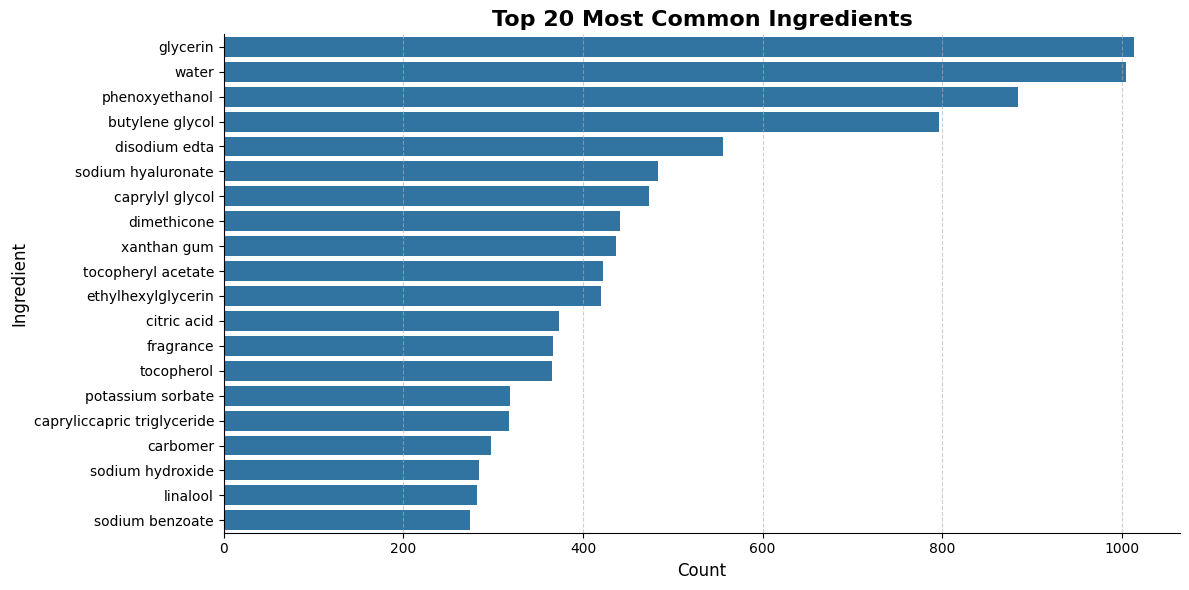

In [18]:
# Get top 20 ingredients by frequency
top_ingredients = (
    cosmetic_exploded['ingredient_list']
    .dropna()
    .value_counts()
    .head(20)
    .reset_index()
)

top_ingredients.columns = ['ingredient', 'count']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_ingredients,
    x='count',
    y='ingredient'
)

# Styling
plt.title('Top 20 Most Common Ingredients', fontsize=16, weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Ingredient', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.show()


- Glycerin emerges as the most common ingredient, surpassing water.
- A relatively small number of ingredients dominate most formulations.
- Overall ingredient usage follows a long-tail distribution.

### Ingredient Count by Product Type

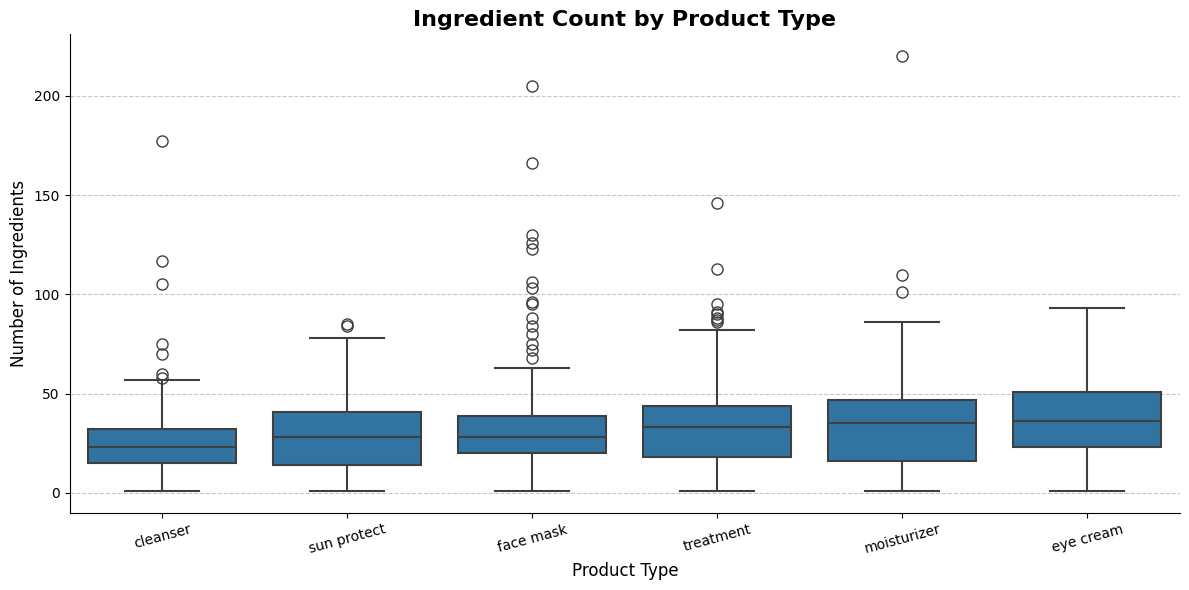

In [19]:
# Sort product types by mean number of ingredients
mean_ingredients = (
    cosmetic.groupby('product_type')['num_ingredients']
            .mean()
            .sort_values()
)

ordered_product_types = mean_ingredients.index

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=cosmetic,
    x='product_type',
    y='num_ingredients',
    order=ordered_product_types,
    legend=False,
    linewidth=1.5,
    fliersize=8
)

plt.title('Ingredient Count by Product Type', fontsize=16, weight='bold')
plt.xlabel('Product Type', fontsize=12)
plt.ylabel('Number of Ingredients', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()


- On average, products contain 20 to 40 ingredients, reflecting moderate formulation complexity:

In [20]:
ingredient_by_type = (
    cosmetic.groupby('product_type')['num_ingredients']
            .agg(['count', 'mean', 'median'])
            .round(1)
            .sort_values('mean')
)

ingredient_by_type

,count,mean,median
product_type,,,
cleanser,281,24.6,23.0
sun protect,170,28.6,28.0
face mask,266,31.3,28.0
treatment,248,32.7,33.0
moisturizer,298,33.6,35.0
eye cream,209,35.5,36.0


### Product Price Distribution

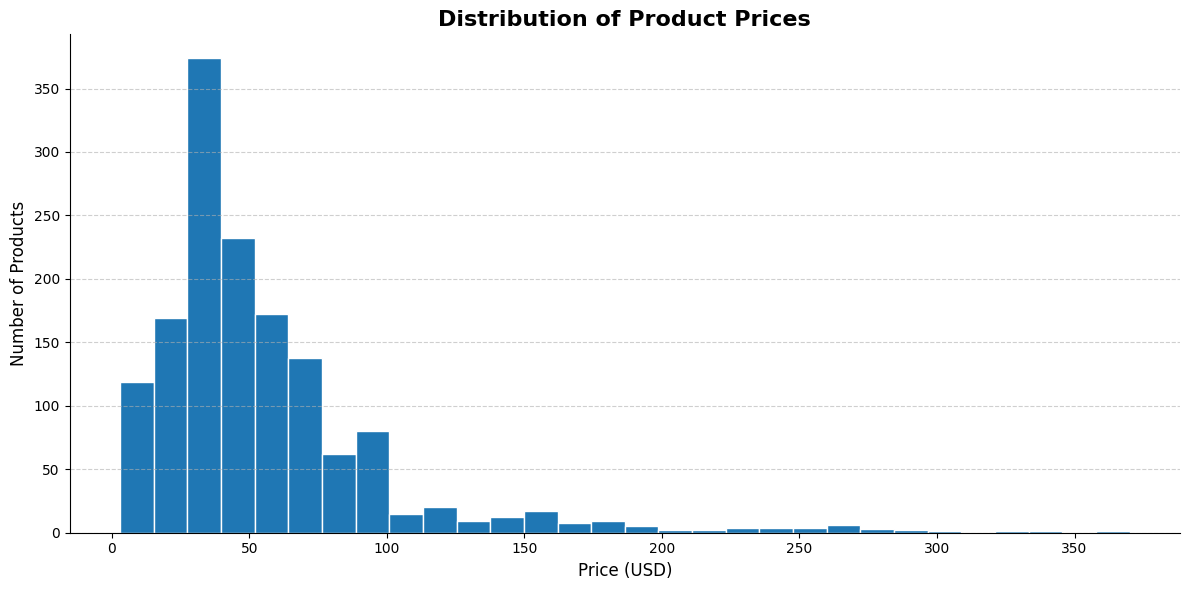

In [21]:
# Price distribution (exclude missing or zero prices)
prices = cosmetic['price'].dropna()
prices = prices[prices > 0]

plt.figure(figsize=(12, 6))
plt.hist(prices, bins=30, edgecolor='white')
plt.title('Distribution of Product Prices', fontsize=16, weight='bold')
plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.show()

- The skewed distribution shows most products clustered in lower price ranges (around $38).
- A small number of luxury-priced outliers raise the average.

### Product Price and Ranking

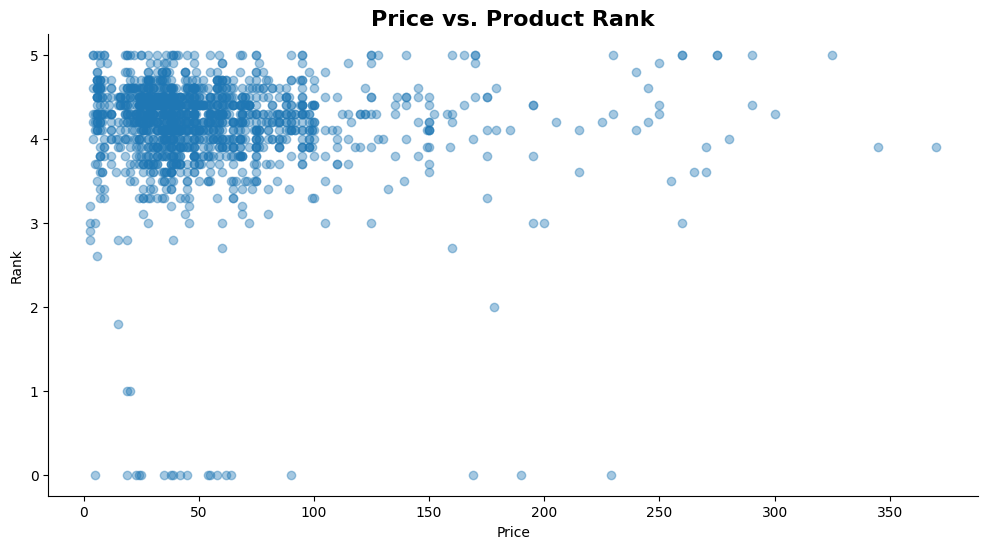

In [22]:
# Price vs. rank
plt.figure(figsize=(12, 6))
plt.scatter(cosmetic['price'], cosmetic['rank'], alpha=0.4)
plt.title('Price vs. Product Rank', fontsize=16, weight='bold')
plt.xlabel('Price')
plt.ylabel('Rank')
sns.despine()
plt.show()

- No strong linear relationship between price and ranking suggests that higher-priced products do not consistently receive better rankings.

## 6. Database Design & Creation

This project uses SQLite to enforce relational integrity and support SQL-based analysis.

**Tables**

- Products
- Ingredients
- ProductIngredients (many-to-many)
- ChemicalReports

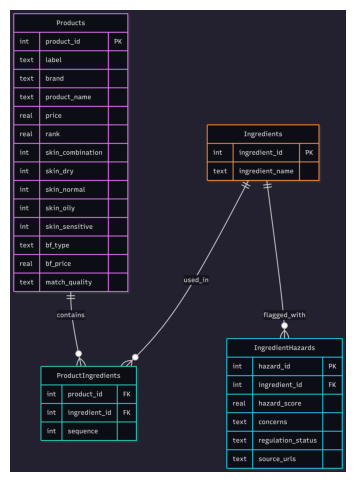

In [23]:
img = Image.open("schema/beauty_wizard_ERD.png")
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis("off")
plt.show()
plt.close()

### Database Schema Creation

In [24]:
# Create SQLite3 database schema
conn = sqlite3.connect("BeautyWiz.db")
conn.execute("PRAGMA foreign_keys = ON;");

In [25]:
conn.executescript("""
DROP TABLE IF EXISTS ProductIngredients;
DROP TABLE IF EXISTS ChemicalReports;
DROP TABLE IF EXISTS Ingredients;
DROP TABLE IF EXISTS Products;

CREATE TABLE Products (
    product_id INTEGER PRIMARY KEY,
    brand TEXT,
    product_name TEXT,
    price REAL,
    rank REAL,
    product_type TEXT
);

CREATE TABLE Ingredients (
    ingredient_id INTEGER PRIMARY KEY,
    ingredient_name TEXT UNIQUE
);

CREATE TABLE ProductIngredients (
    product_id INTEGER,
    ingredient_id INTEGER,
    FOREIGN KEY (product_id) REFERENCES Products(product_id),
    FOREIGN KEY (ingredient_id) REFERENCES Ingredients(ingredient_id)
);

CREATE TABLE ChemicalReports (
    report_id INTEGER PRIMARY KEY,
    brand OBJECT,
    product_name OBJECT,
    ingredient_id INTEGER,
    chemicalid INTEGER,
    chemicalname OBJECT,
    initialdatereported OBJECT,
    mostrecentdatereported OBJECT,
    discontinueddate OBJECT,
    chemicalcount OBJECT,
    FOREIGN KEY (ingredient_id) REFERENCES Ingredients(ingredient_id)
);
""");


### Populate Database

In [26]:
# Data insert helper
def insert_sql(df, table, columns):
    df[columns].to_sql(
        table,
        conn,
        if_exists="append",
        index=False
    )

In [27]:
# Insert cleaned product data into database
products_df = cosmetic_cleaned[[
    "brand",
    "product_name",
    "price",
    "rank",
    "product_type"
]]

products_df.to_sql(
    "Products",
    conn,
    if_exists="append",
    index=False
)

1472

In [28]:
# Insert cleaned ingredient data into database
ingredients_df = (
    cosmetic_cleaned["ingredient_list"]
    .explode()
    .dropna()
    .str.strip()
    .drop_duplicates()
    .to_frame(name="ingredient_name")
)

ingredients_df.to_sql(
    "Ingredients",
    conn,
    if_exists="append",
    index=False
)

5366

In [29]:
# Creating ProductIngredients join
# Get IDs
product_ids = pd.read_sql("SELECT product_id, brand, product_name FROM Products", conn)
ingredient_ids = pd.read_sql("SELECT ingredient_id, ingredient_name FROM Ingredients", conn)

product_lookup = product_ids.set_index(["brand", "product_name"])["product_id"]
ingredient_lookup = ingredient_ids.set_index("ingredient_name")["ingredient_id"]

rows = []

for _, row in cosmetic_cleaned.iterrows():
    pid = product_lookup.get((row.brand, row.product_name))
    if pid is None:
        continue
    for ing in row.ingredient_list:
        iid = ingredient_lookup.get(ing)
        if iid is not None:
            rows.append((pid, iid))

junction_df = pd.DataFrame(rows, columns=["product_id", "ingredient_id"])

junction_df.to_sql(
    "ProductIngredients",
    conn,
    if_exists="append",
    index=False
)

45667

In [30]:
# Map ingredient names to ingredient_id
ingredient_lookup = ingredient_ids.set_index("ingredient_name")["ingredient_id"]

cscp_for_sql = cscp_cleaned.copy()

cscp_for_sql["ingredient_id"] = (
    cscp_for_sql["chemicalname"]
    .str.lower()
    .str.strip()
    .map(ingredient_lookup)
)

In [31]:
# Drop rows that do not match
cscp_for_sql = cscp_for_sql.dropna(subset=["ingredient_id"])

In [32]:
# Align to table schema
chemical_reports_df = cscp_for_sql.reindex(columns=[
    "brand",
    "product_name",
    "ingredient_id",
    "chemicalid",
    "chemicalname",
    "initialdatereported",
    "mostrecentdatereported",
    "discontinueddate",
    "chemicalcount"
])

In [33]:
# Insert chemical reporting data
insert_sql(
    chemical_reports_df,
    "ChemicalReports",
    [
        "brand",
        "product_name",
        "ingredient_id",
        "chemicalid",
        "chemicalname",
        "initialdatereported",
        "mostrecentdatereported",
        "discontinueddate",
        "chemicalcount"
    ]
)

- Original report identifiers from the source dataset were not used as primary keys. Instead, SQLite-generated identifiers were used to ensure uniqueness and avoid duplicate insert conflicts.

## 7. Advanced SQL Querying


### Regulatory Reporting

- Ingredients appearing in CSCP reports
- Report frequency and discontinuation flags

In [34]:
# SQL-Derived Metrics: Ingredient Counts
ingredient_counts = pd.read_sql("""
SELECT product_id, COUNT(*) AS ingredient_count
FROM ProductIngredients
GROUP BY product_id
""", conn)

### Query 1: Ingredient complexity by brand

Which brands tend to use more complex formulations (more ingredients per product)?

In [35]:
# Average ingredients per product by brand
query_brand_complexity = '''
SELECT
    p.brand,
    COUNT(DISTINCT pi.ingredient_id) * 1.0
        / COUNT(DISTINCT p.product_id) AS avg_ingredients_per_product,
    COUNT(DISTINCT p.product_id) AS product_count
FROM Products p
JOIN ProductIngredients pi
    ON p.product_id = pi.product_id
GROUP BY p.brand
HAVING COUNT(DISTINCT p.product_id) >= 5
ORDER BY avg_ingredients_per_product DESC;
'''

df_brand = pd.read_sql(query_brand_complexity, conn)

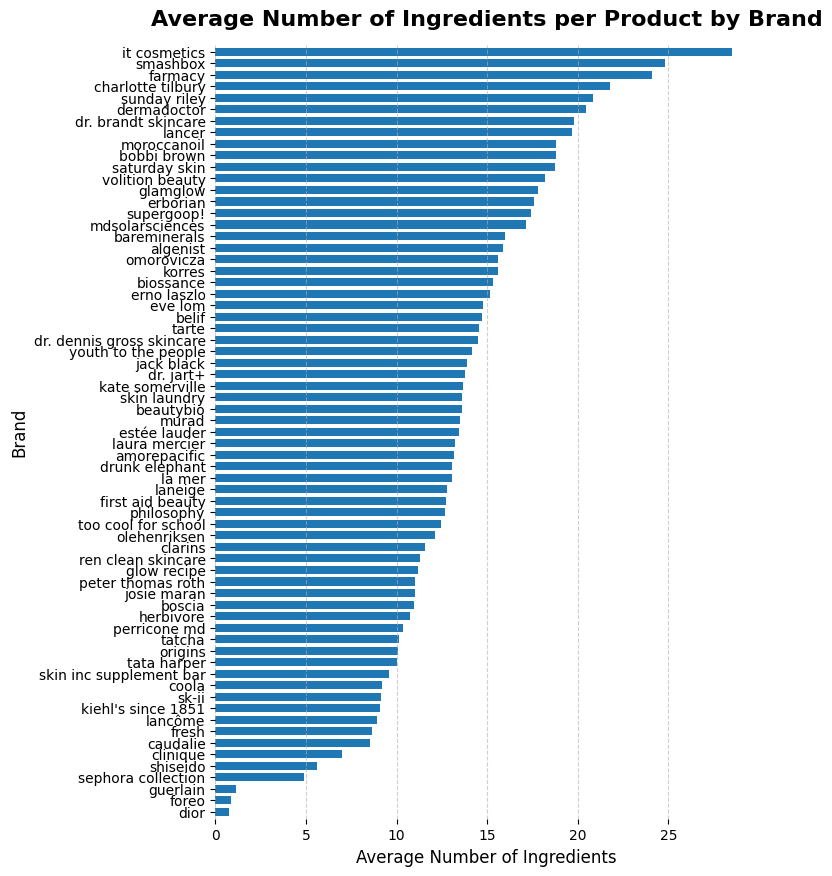

In [81]:
# Q1 Visualization
df_brand_sorted = df_brand.sort_values("avg_ingredients_per_product")
n_brands = df_brand_sorted.shape[0]
fig_height = max(7, n_brands * 0.15)
df_brand_sorted.plot(
    kind="barh",
    x="brand",
    y="avg_ingredients_per_product",
    legend=False,
    width=0.7,
    figsize=(7, fig_height)
)
plt.title("Average Number of Ingredients per Product by Brand",
    fontsize=16,
    weight="bold",
    pad=14)
plt.xlabel("Average Number of Ingredients", fontsize=12)
plt.ylabel("Brand", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.6)
sns.despine(left=True, bottom=True,)
plt.show()

- This analysis compares average formulation complexity across brands by measuring the number of unique ingredients used per product. Brands with higher averages tend to produce more complex formulations.
- Note: This chart measures average formulation complexity by brand, not ingredient prevalence. Earlier results showing water as the most common ingredient were calculated at the ingredient level across all products, and are therefore not directly comparable.

### Query 2: Most Widely Used Ingredients Across Products

Which ingredients appear most frequently across cosmetic products?

In [38]:
# Ingredient prevalence
query_ingredients = '''
SELECT
    i.ingredient_name,
    COUNT(DISTINCT pi.product_id) AS product_count
FROM Ingredients i
JOIN ProductIngredients pi
    ON i.ingredient_id = pi.ingredient_id
GROUP BY i.ingredient_name
HAVING COUNT(DISTINCT pi.product_id) >= 20
ORDER BY product_count DESC
LIMIT 25;
'''

df_top_ingredients = pd.read_sql(query_ingredients, conn)

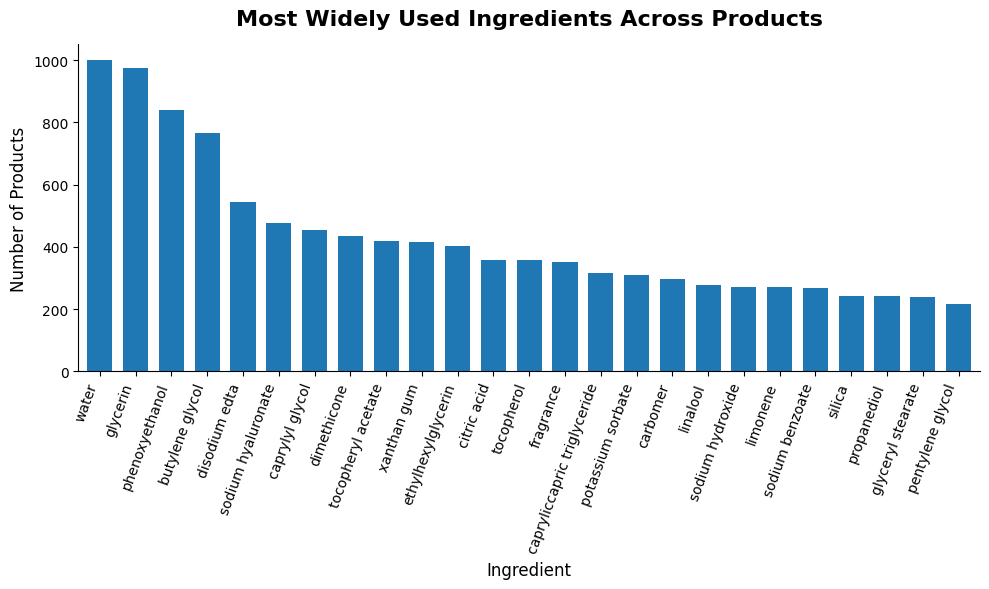

In [ ]:
# Q2 Visualization
df_top_ingredients.plot(
    kind="bar",
    x="ingredient_name",
    y="product_count",
    legend=False,
    figsize=(10, 6),
    width=0.7
)
plt.title("Most Widely Used Ingredients Across Products", fontsize=16,
    weight="bold",
    pad=14)
plt.xlabel("Ingredient", fontsize=12)
plt.ylabel("Number of Products", fontsize=12)
plt.xticks(rotation=70, ha="right", fontsize=10)
plt.tight_layout()
sns.despine(top=True, right=True)
plt.show()

- This query identifies ingredients that appear most frequently across cosmetic products, highlighting formulation staples that dominate product compositions.
- Unlike Q1, this chart focuses on ingredient frequency across products rather than brand-level formulation averages.

### Query 3: Products with Regulatory History

This analysis identifies cosmetic products and brands that include ingredients appearing in the California Safe Cosmetics Program (CSCP) reporting records.

Regulatory exposure is measured at the ingredient level, not by the frequency of enforcement actions. An ingredient is considered regulated if it appears at least once in the regulatory reporting dataset.

#### Product-level analysis

The product-level query counts the number of distinct ingredients per product that have any associated regulatory record. This highlights products with a higher concentration of ingredients that have been subject to regulatory reporting, regardless of how often those ingredients were reported.

In [40]:
# Products with chemical reporting records
query_top_products_regulated_ingredients = """
SELECT
    p.brand,
    p.product_name AS product,
    COUNT(DISTINCT pi.ingredient_id) AS regulated_ingredient_count
FROM Products p
JOIN ProductIngredients pi
    ON p.product_id = pi.product_id
JOIN ChemicalReports cr
    ON pi.ingredient_id = cr.ingredient_id
GROUP BY p.product_id
ORDER BY regulated_ingredient_count DESC
LIMIT 10;
"""

df_top_products = pd.read_sql(query_top_products_regulated_ingredients, conn)
df_top_products

,brand,product,regulated_ingredient_count
0,philosophy,a glowing regimen trial set,4
1,peter thomas roth,retinol fusion pm eye cream,4
2,klorane,bb eye cream with soothing cornflower,4
3,shiseido,bio-performance glow revival cream,3
4,shiseido,ibuki protective moisturizer broad spectrum sp...,3
5,shiseido,white lucent all day brightener broad spectrum...,3
6,peter thomas roth,un-wrinkle turbo™ line smoothing toning lotion,3
7,murad,advanced acne & wrinkle reducer,3
8,algenist,reveal concentrated color correcting drops,3
9,origins,mini mask musts,3


#### Brand-level analysis

The brand-level query aggregates regulatory exposure across all products sold by each brand. Two metrics are reported:
- Regulated ingredient count: the number of unique ingredients used by the brand that appear in regulatory records
- Total regulatory events: the total number of distinct regulatory report entries associated with those ingredients

In [41]:
# Brands with chemical reporting records
query_brand_exposure = """
WITH brand_ingredients AS (
    SELECT DISTINCT
        p.brand,
        cr.ingredient_id,
        cr.report_id
    FROM Products p
    JOIN ProductIngredients pi
        ON p.product_id = pi.product_id
    JOIN ChemicalReports cr
        ON pi.ingredient_id = cr.ingredient_id
)
SELECT
    brand,
    COUNT(DISTINCT ingredient_id) AS regulated_ingredient_count,
    COUNT(DISTINCT report_id) AS total_regulatory_events
FROM brand_ingredients
GROUP BY brand
ORDER BY total_regulatory_events DESC;
"""

#Brand hazard summary
df_brand_hazards = pd.read_sql(query_brand_exposure, conn)
df_brand_hazards.head(20)

,brand,regulated_ingredient_count,total_regulatory_events
0,murad,8,99450
1,peter thomas roth,7,98903
2,kiehl's since 1851,6,98633
3,algenist,7,98490
4,shiseido,7,97730
5,amorepacific,5,97452
6,philosophy,6,97354
7,dr. brandt skincare,6,97354
8,dermadoctor,5,97084
9,klorane,4,96997


- Regulatory exposure is uneven across brands, with a small subset using ingredients that appear frequently in reporting records. 
- High total counts reflect repeated reporting of widely used ingredients over time rather than product-level violations or elevated safety risk.

## Key Findings

- A small subset of ingredients dominates cosmetic formulations, while most products include a long tail of low-frequency ingredients.
- Regulatory reporting is concentrated among relatively few chemicals.
- Ingredient diversity does not strongly correlate with price.

---

## Limitations

- Ingredient presence does not imply concentration or exposure level.
- Regulated ingredient reports are source-dependent and not definitive safety measures.
- Dataset coverage varies by brand and product category.

---

## Next Steps

Future extensions could include:

- Automated data refresh
- API-driven product lookups
- Integration of consumer review sentiment

---



> **Reproducibility Notes**
> - All work performed via command-line Git commits.
> - No file uploader used after initial dataset acquisition.
> - Notebook structured for portfolio and PDF export (if needed).